# Lab5: Nonlinear Constrained Finite Time Optimal Control (CFTOC) with Pyomo

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I

***

These notes were developed by Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

If you are enrolled in ME C231A/EE C220B you may take notes and make copies of course materials for your own use. You may also share those materials with another student who is registered and enrolled in this course, and with DSP.

You may not reproduce, distribute or display (post/upload) (Links to an external site.) lecture notes or recordings or course materials in any other way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Links to an external site.Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

***

In *this* lab, we will formulate and solve a tracking problem for a nonlinear system as a Constrained Finite Time Optimal Control (CFTOC) problem.

In [1]:
# This cell is commented out because Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab.

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 120876 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected pac

# Problem Statement
Consider a nonlinear, time-invariant, continuous-time system with two states \{$x_1,x_2$\}, one input $u$, and given parameters $\gamma$ and $\tau$.

\begin{equation}
\begin{split}
% {\dot x}_1 =& \sin(x_1) + \frac{\gamma}{1+x_1^2} \tan^{-1} (x_2),\\
 {\dot x}_1 =& \sin(x_1) + \gamma \tan^{-1} (x_2),\\
{\dot x}_2 =& \frac{1}{\tau} ( x_2 - u ).
\end{split}
\end{equation}

The control objective is to let $x_1$ track a desired trajectory (given), under the following input and terminal state constraints.

\begin{align}
\mid \dot{u} \mid &< 0.02 \\
\mid x_{1}(t_{final}) - x_{1,desired}(t_{final}) \mid &\leq 0.025 x_{1,desired}(t_{final})
\end{align}

# Euler Discretization
Assume the sampling time is $T_s$. With Euler discretization, the model is
\begin{equation}
\begin{split}
x_1(k+1) = & x_1(k) +T_s\left(\sin(x_1(k)) + {\gamma}\tan^{-1}( x_2(k))\right)\\
% x_1(k+1) = & x_1(k) +T_s\left(\sin(x_1(k)) + \frac{\gamma}{1+x_1^2(k)}\tan^{-1}(x_2(k))\right)\\
x_2(k+1) = & x_2(k) + \frac{T_s}{\tau}(x_2(k) - u(k))
\end{split}
\end{equation}

Use the function ${\tt disc\_dyn}$ to simulate the discrete-time dynamics after solving the CFTOC problem.

In [2]:
# System parameters and simulation setting
import matplotlib.pyplot as plt
import numpy as np
import scipy as cp

# x is state vector, u is input, Ts is sampling period, gamma and tau are parameters
def disc_dyn(x, u ,Ts, gamma, tau, nx):
    x_next = np.empty((nx,))
    x_next[0] = x[0] + Ts*(np.sin(x[0]) + gamma*np.arctan(x[1]))
    x_next[1] = x[1] + Ts/tau * (x[1] - u)
    return x_next

Note that the code above is not the best way to code the discrete-time model. It is better to have a general Euler discretization function that uses, as one of its input arguments, a handle to another function where the particular nonlinear, continuous-time model is written up.  Try to make functions as general as possible and avoid hard-coding values or expressions that make your code work for only a specific application.

# Finite Constrained Optimization Problem
Now set up the CFTOC problem and simulation code. Begin by defining the system parameters and the simulation settings.

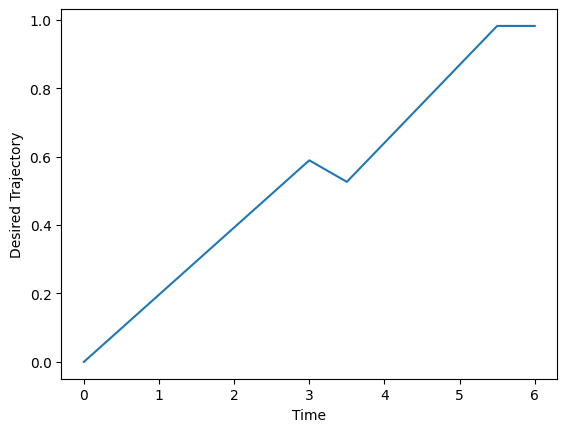

In [3]:
# System parameters and simulation setting
import matplotlib.pyplot as plt
import numpy as np

# system parameter
tau    = 0.2
gamma  = 10

# simulation parameters
Ts     = 0.05
N      = 120
TFinal = Ts*N

# We plot the desired trajectory.

# Given desired trajectory
tValues    = [0, 3, 3.5, 5.5, 6]
xDesValues = [0, 0.75*np.pi/4, 0.67*np.pi/4, 1.25*np.pi/4, 1.25*np.pi/4]

plt.plot(tValues, xDesValues)
plt.xlabel('Time')
plt.ylabel('Desired Trajectory')
plt.show()

# Interpolation Step

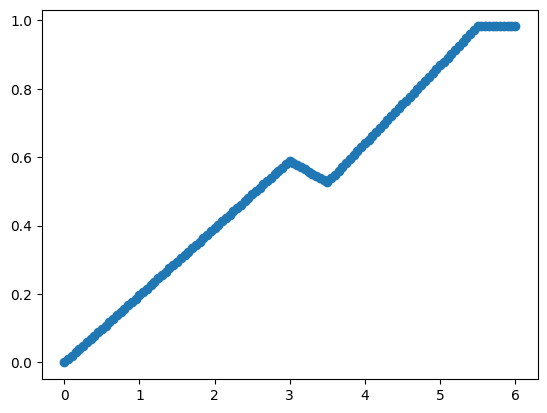

In [4]:
from scipy import interpolate

f = interpolate.interp1d(tValues, xDesValues, 'linear')
tGrid = np.linspace(tValues[0], tValues[-1], N+1)
xDesired = f(tGrid)
plt.scatter(tGrid, xDesired)
plt.show()

# Now we formulate the CFTOC problem with Pyomo

In [5]:
# Finite constrained optimiation problem
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

udotlim = 0.02

nx = 2         # number of states
nu = 1         # number of inputs

model = pyo.ConcreteModel()
model.tidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
model.xidx = pyo.Set(initialize=range(0, nx))
model.uidx = pyo.Set(initialize=range(0, nu))

# Create state and input variables trajectory:
model.x = pyo.Var(model.xidx, model.tidx) #nx x N
model.u = pyo.Var(model.uidx, model.tidx)

# Objective:
model.cost = pyo.Objective(expr = sum((model.x[0, t] - xDesired[t])**2 for t in model.tidx if t < N), sense=pyo.minimize)

# Constraints:

model.constraint1 = pyo.Constraint(model.xidx, rule=lambda model, i: model.x[i, 0] == 0.0) #Initial condition

model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[0, t+1] == model.x[0, t] + Ts*(pyo.sin(model.x[0, t])+gamma*pyo.atan(model.x[1, t]))
                                   if t < N else pyo.Constraint.Skip)

model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t+1] == model.x[1, t] + (Ts/tau)*(model.x[1, t]-model.u[0, t])
                                   if t < N else pyo.Constraint.Skip)

model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] <= +Ts*udotlim
                                   if t < N-1 else pyo.Constraint.Skip)

model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] >= -Ts*udotlim
                                   if t < N-1 else pyo.Constraint.Skip)

model.constraint6 = pyo.Constraint(expr = 0.975*xDesired[N] - model.x[0, N] <= 0.0)
model.constraint7 = pyo.Constraint(expr = model.x[0, N] - 1.025*xDesired[N] <= 0.0)

# Now we can solve:
results = pyo.SolverFactory('ipopt').solve(model).write()
# model.display()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 482
  Number of variables: 362
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.03894662857055664
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


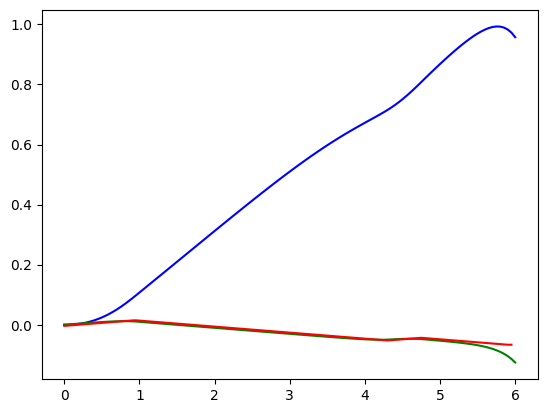

In [6]:
# plot results
x1 = [pyo.value(model.x[0,0])]
x2 = [pyo.value(model.x[1,0])]
u1 = [pyo.value(model.u[0,0])]

for t in model.tidx:
    if t < N:
        x1.append(pyo.value(model.x[0,t+1]))
        x2.append(pyo.value(model.x[1,t+1]))
    if t < N-1:
        u1.append(pyo.value(model.u[0,t+1]))
plt.figure()
plt.plot(tGrid, x1,'b')
plt.plot(tGrid, x2,'g')
plt.plot(tGrid[0:-1], u1,'r')
plt.show()

We then apply the optimal control sequence to the nonlinear, discrete-time system to get the actual states $x$. Note that we are simulating on a discrete-time model. If you have the time later, apply the optimal control sequence to the continuous-time model by assuming constant $u(t)$ during the sampling interval.

In [7]:
# Simulate on discretized model using optimal input values
x_actual = np.zeros((nx, N+1)) # this vector will store the actual x values.
for t in range(N):
    x_actual[:,t+1] = disc_dyn(x_actual[:,t], u1[t], Ts, gamma, tau, nx)

$\textbf{Task:}$ Plot $x_1$ against time with different "control_rate_limit" (try a faster rate limit), and compare it with the desired trajectory.

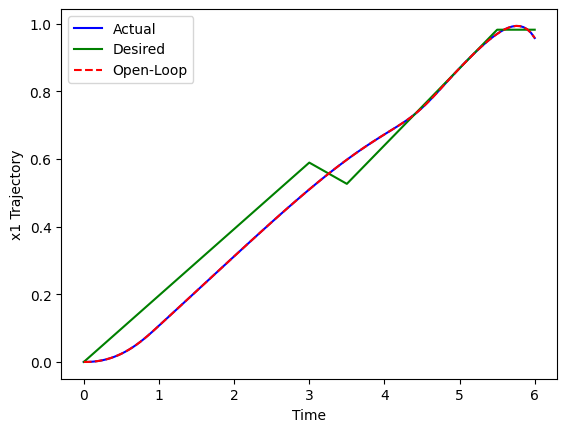

In [8]:
plt.figure()
plt.plot(tGrid, x_actual[0,:], 'b')
plt.plot(tGrid, xDesired, 'g')
plt.plot(tGrid, x1, '--r')
plt.legend(['Actual', 'Desired', 'Open-Loop'])
plt.xlabel('Time')
plt.ylabel('x1 Trajectory')
plt.show()

$\textbf{Question:}$ What is the disadvantage of this method? Try to plot the real value $x_1$ against the predicted $x_1$ value. What if there is a parameter uncertainty in the plant? Will the predicted  $x_1$ be the same as the actual value $x_1$?
You can use and modify the following  $\texttt{disc_uncdyn}$ function

In [9]:
# x is state vector, u is input, Ts is sampling period, gamma and tau are parameters
def disc_uncdyn(x, u ,Ts, gamma, tau, nx):
    uncertainty = 0.5
    x_next = np.empty((nx,))
    x_next[0] = x[0] + Ts*(np.sin(x[0]) + (gamma+uncertainty)*np.arctan(x[1]))
    x_next[1] = x[1] + Ts/tau * (x[1] - u)
    return x_next

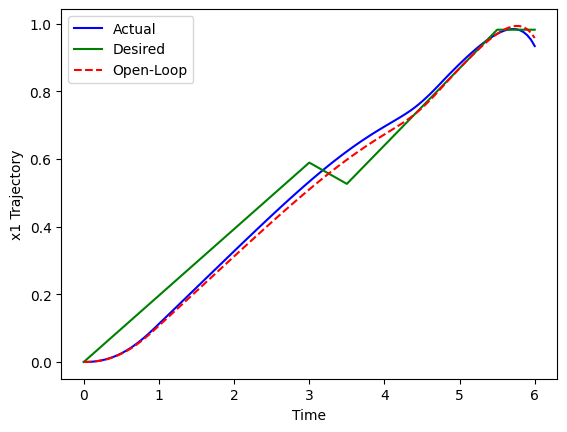

In [10]:
# Simulate on discretized model using optimal input values
x_actual_unc = np.zeros((nx, N+1)) # this vector will store actual x value
for t in range(N):
    x_actual_unc[:,t+1] = disc_uncdyn(x_actual_unc[:,t], u1[t], Ts, gamma, tau, nx)

plt.figure()
plt.plot(tGrid, x_actual_unc[0,:], 'b')
plt.plot(tGrid, xDesired, 'g')
plt.plot(tGrid, x1, '--r')
plt.legend(['Actual', 'Desired', 'Open-Loop'])
plt.xlabel('Time')
plt.ylabel('x1 Trajectory')
plt.show()